# Welding Price Prediction - Exploratory Data Analysis

In this notebook, we'll explore the welding workshop dataset and visualize the relationships between features and the target variable (Harga Akhir).

In [1]:
%pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Load the dataset
df = pd.read_excel('dataset_bengkel_las2.xlsx', sheet_name='Dataset Transaksi')

# Display basic information
print("Dataset shape:", df.shape)
print("\nColumn names:")
for col in df.columns:
    print(f"- {col}")
    
print("\nFirst 5 rows:")
df.head()

Dataset shape: (121, 11)

Column names:
- ID Transaksi
- Produk
- Jumlah Unit
- Jumlah Lubang
- Ukuran (m²)
- Jenis Material
- Ketebalan (mm)
- Finishing
- Kerumitan Desain
- Metode Hitung
- Harga Akhir (Rp)

First 5 rows:


,ID Transaksi,Produk,Jumlah Unit,Jumlah Lubang,Ukuran (m²),Jenis Material,Ketebalan (mm),Finishing,Kerumitan Desain,Metode Hitung,Harga Akhir (Rp)
0,1,Teralis,1,7.0,0.0,Hollow,1.0,Powder Coating,Menengah,Per Lubang,3578000.0
1,2,Pintu Gerbang,1,NaN,11.2,Besi Siku,2.3,Tanpa Cat,Sederhana,Per Unit,16100000.0
2,3,Teralis,1,NaN,4.3,Plat,1.0,Cat Duco,Sederhana,Per Lubang,100000.0
3,4,Pagar,1,NaN,19.3,Besi Siku,2.0,Cat Semprot,Menengah,Per m²,32277140.0
4,5,Teralis,1,7.0,0.0,Aluminium,1.5,Cat Duco,Sederhana,Per Lubang,3239500.0


In [3]:
# Check for missing values
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


ID Transaksi          0
Produk                0
Jumlah Unit           0
Jumlah Lubang       105
Ukuran (m²)           0
Jenis Material        0
Ketebalan (mm)        0
Finishing             0
Kerumitan Desain      0
Metode Hitung         0
Harga Akhir (Rp)      0
dtype: int64

In [4]:
# Basic statistics for numeric columns
df.describe()

,ID Transaksi,Jumlah Unit,Jumlah Lubang,Ukuran (m²),Ketebalan (mm),Harga Akhir (Rp)
count,121.000000,121.0,16.000000,121.000000,121.000000,1.210000e+02
mean,61.000000,1.0,7.812500,19.380992,1.333058,2.212766e+07
std,35.073732,0.0,0.403113,12.579456,0.497056,1.806217e+07
min,1.000000,1.0,7.000000,0.000000,0.800000,5.000000e+04
25%,31.000000,1.0,8.000000,11.400000,0.900000,1.054000e+07
50%,61.000000,1.0,8.000000,18.000000,1.200000,1.685426e+07
75%,91.000000,1.0,8.000000,27.400000,1.800000,2.922150e+07
max,121.000000,1.0,8.000000,49.800000,2.300000,1.031222e+08


## Target Variable Analysis

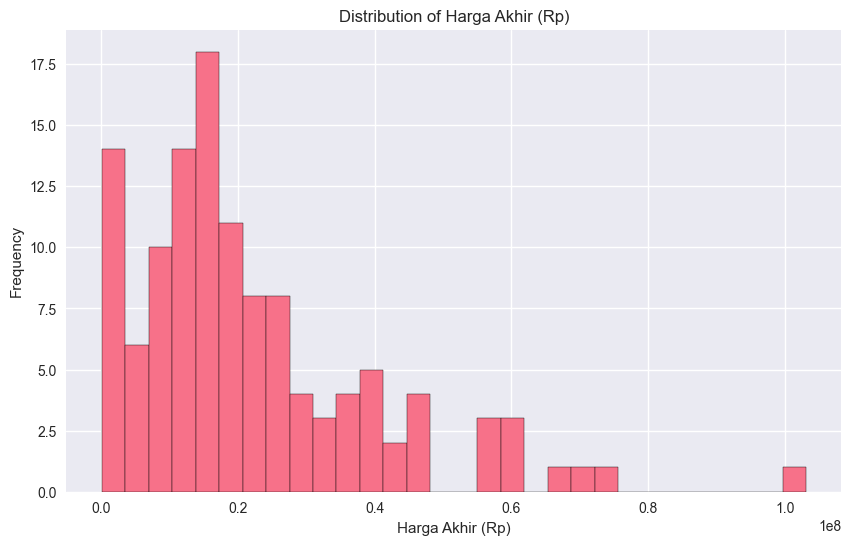

Mean price: Rp 22,127,664
Median price: Rp 16,854,260
Min price: Rp 50,000
Max price: Rp 103,122,200


In [5]:
# Distribution of target variable (Harga Akhir)
plt.figure(figsize=(10, 6))
plt.hist(df['Harga Akhir (Rp)'], bins=30, edgecolor='black')
plt.title('Distribution of Harga Akhir (Rp)')
plt.xlabel('Harga Akhir (Rp)')
plt.ylabel('Frequency')
plt.show()

print(f"Mean price: Rp {df['Harga Akhir (Rp)'].mean():,.0f}")
print(f"Median price: Rp {df['Harga Akhir (Rp)'].median():,.0f}")
print(f"Min price: Rp {df['Harga Akhir (Rp)'].min():,.0f}")
print(f"Max price: Rp {df['Harga Akhir (Rp)'].max():,.0f}")

## Categorical Features Analysis

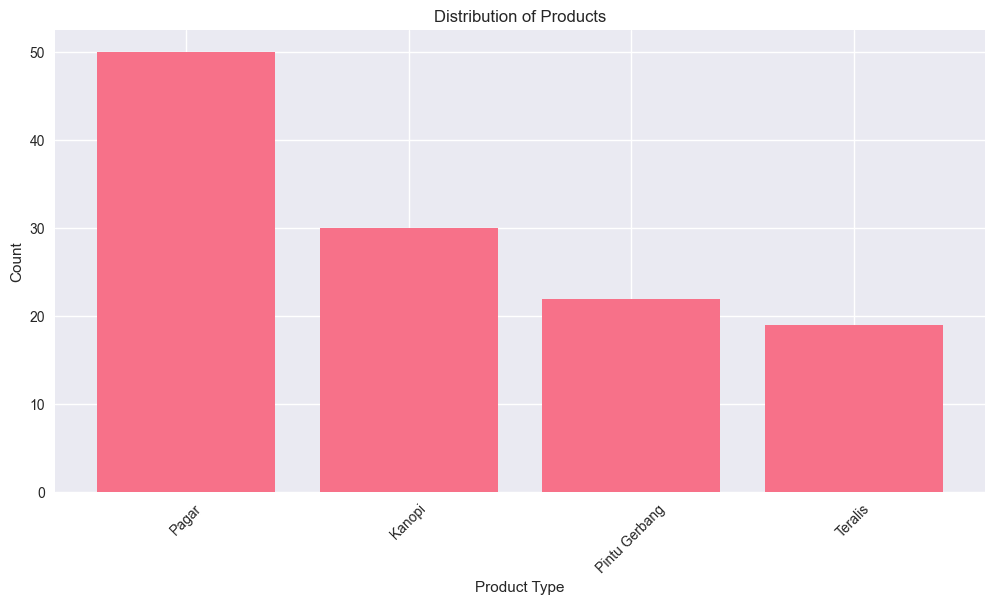

Product distribution:
Produk
Pagar            50
Kanopi           30
Pintu Gerbang    22
Teralis          19
Name: count, dtype: int64


In [6]:
# Distribution of products
plt.figure(figsize=(12, 6))
product_counts = df['Produk'].value_counts()
plt.bar(product_counts.index, product_counts.values)
plt.title('Distribution of Products')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print("Product distribution:")
print(product_counts)

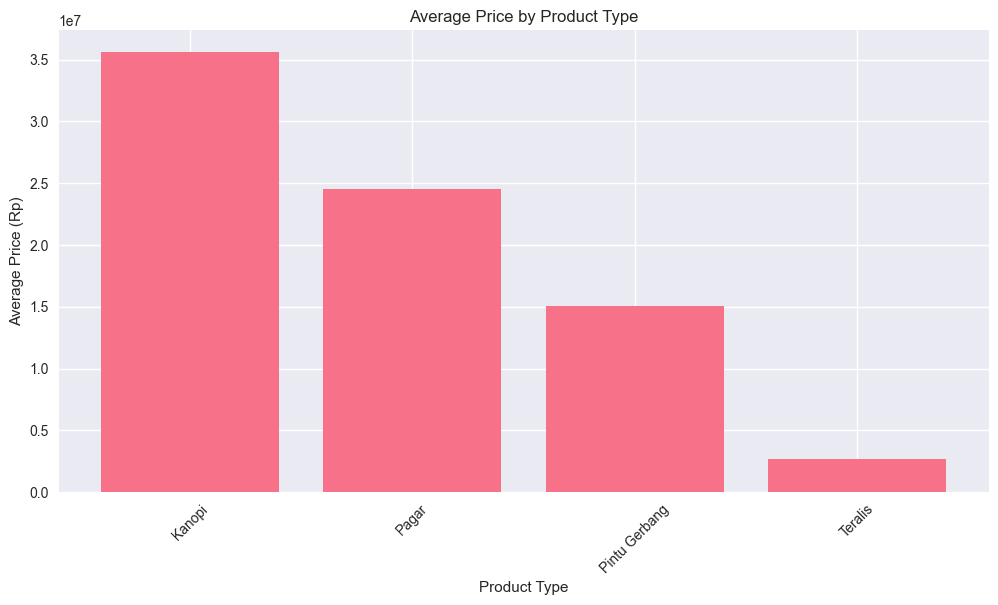

Average price by product type:
Kanopi: Rp 35,594,414
Pagar: Rp 24,555,429
Pintu Gerbang: Rp 15,038,996
Teralis: Rp 2,683,447


In [7]:
# Average price by product type
plt.figure(figsize=(12, 6))
avg_price_by_product = df.groupby('Produk')['Harga Akhir (Rp)'].mean().sort_values(ascending=False)
plt.bar(avg_price_by_product.index, avg_price_by_product.values)
plt.title('Average Price by Product Type')
plt.xlabel('Product Type')
plt.ylabel('Average Price (Rp)')
plt.xticks(rotation=45)
plt.show()

print("Average price by product type:")
for product, price in avg_price_by_product.items():
    print(f"{product}: Rp {price:,.0f}")

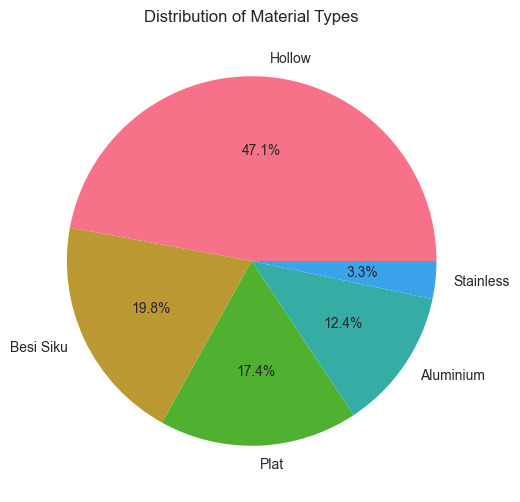

Material distribution:
Jenis Material
Hollow       57
Besi Siku    24
Plat         21
Aluminium    15
Stainless     4
Name: count, dtype: int64


In [8]:
# Distribution of material types
plt.figure(figsize=(10, 6))
material_counts = df['Jenis Material'].value_counts()
plt.pie(material_counts.values, labels=material_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Material Types')
plt.show()

print("Material distribution:")
print(material_counts)

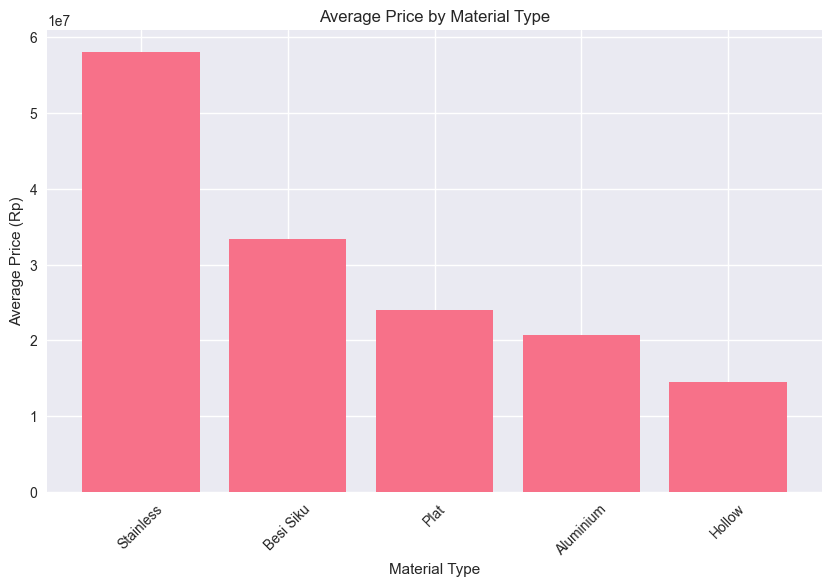

Average price by material type:
Stainless: Rp 58,072,460
Besi Siku: Rp 33,365,264
Plat: Rp 23,952,687
Aluminium: Rp 20,745,269
Hollow: Rp 14,565,012


In [9]:
# Average price by material type
plt.figure(figsize=(10, 6))
avg_price_by_material = df.groupby('Jenis Material')['Harga Akhir (Rp)'].mean().sort_values(ascending=False)
plt.bar(avg_price_by_material.index, avg_price_by_material.values)
plt.title('Average Price by Material Type')
plt.xlabel('Material Type')
plt.ylabel('Average Price (Rp)')
plt.xticks(rotation=45)
plt.show()

print("Average price by material type:")
for material, price in avg_price_by_material.items():
    print(f"{material}: Rp {price:,.0f}")

## Numerical Features Analysis

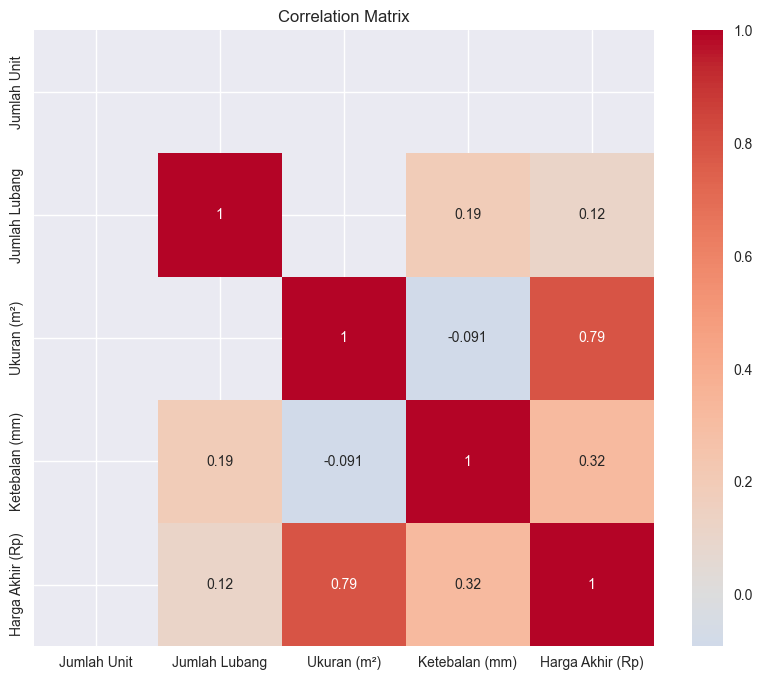

In [10]:
# Correlation matrix for numerical features
numerical_cols = ['Jumlah Unit', 'Jumlah Lubang', 'Ukuran (m²)', 'Ketebalan (mm)', 'Harga Akhir (Rp)']
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

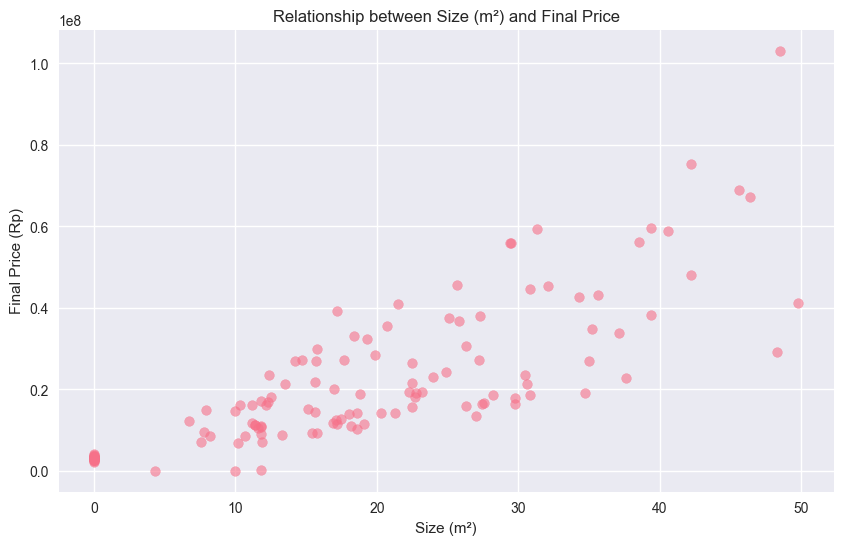

In [11]:
# Relationship between Ukuran (m²) and Harga Akhir
plt.figure(figsize=(10, 6))
plt.scatter(df['Ukuran (m²)'], df['Harga Akhir (Rp)'], alpha=0.6)
plt.title('Relationship between Size (m²) and Final Price')
plt.xlabel('Size (m²)')
plt.ylabel('Final Price (Rp)')
plt.show()

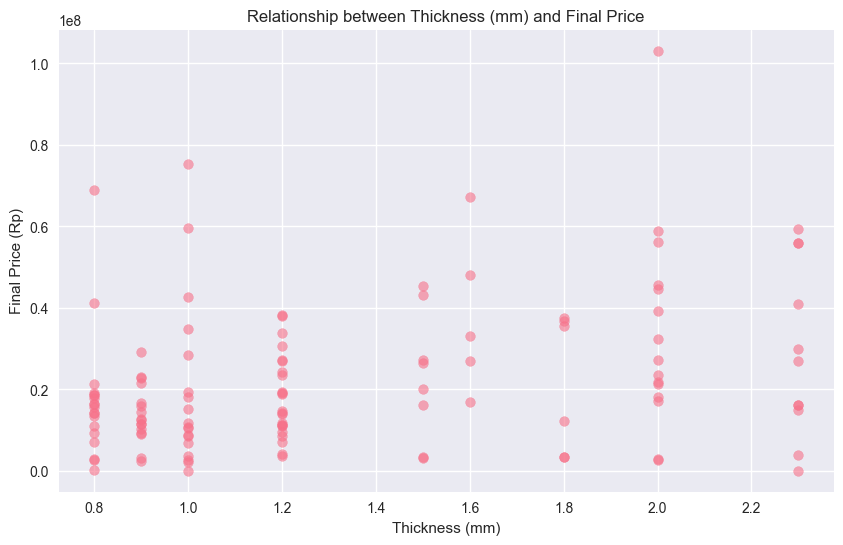

In [12]:
# Relationship between Ketebalan (mm) and Harga Akhir
plt.figure(figsize=(10, 6))
plt.scatter(df['Ketebalan (mm)'], df['Harga Akhir (Rp)'], alpha=0.6)
plt.title('Relationship between Thickness (mm) and Final Price')
plt.xlabel('Thickness (mm)')
plt.ylabel('Final Price (Rp)')
plt.show()

## Feature Engineering Visualization

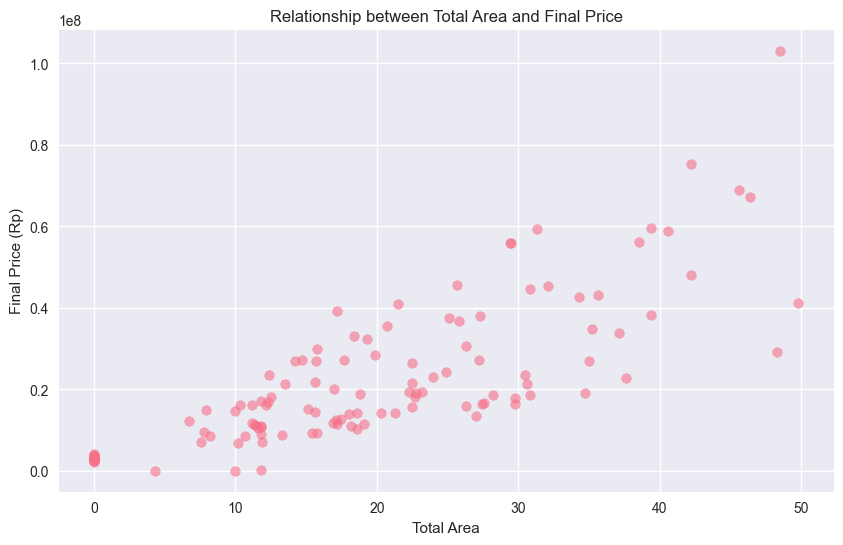

In [13]:
# Create derived features
df['total_area'] = df['Jumlah Unit'] * df['Ukuran (m²)']
df['total_lubang'] = df['Jumlah Unit'] * df['Jumlah Lubang']

# Relationship between total_area and Harga Akhir
plt.figure(figsize=(10, 6))
plt.scatter(df['total_area'], df['Harga Akhir (Rp)'], alpha=0.6)
plt.title('Relationship between Total Area and Final Price')
plt.xlabel('Total Area')
plt.ylabel('Final Price (Rp)')
plt.show()

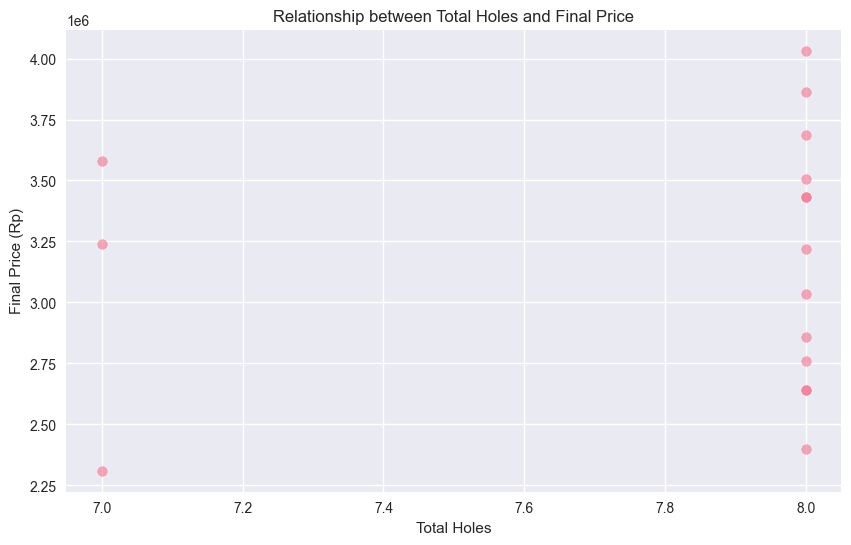

In [14]:
# Relationship between total_lubang and Harga Akhir
plt.figure(figsize=(10, 6))
plt.scatter(df['total_lubang'], df['Harga Akhir (Rp)'], alpha=0.6)
plt.title('Relationship between Total Holes and Final Price')
plt.xlabel('Total Holes')
plt.ylabel('Final Price (Rp)')
plt.show()

## Model Training Results

In [15]:
# Load the metrics from our trained model
import json

with open('metrics.json', 'r') as f:
    metrics = json.load(f)
    
print("=== MODEL EVALUATION RESULTS ===")
print(f"Cross-validation MAE: Rp {metrics['cv_mae']:,.0f} (+/- Rp {metrics['cv_mae_std']:,.0f})")
print(f"Cross-validation R²: {metrics['cv_r2']:.4f} (+/- {metrics['cv_r2_std']:.4f})")
print(f"Test MAE: Rp {metrics['test_mae']:,.0f}")
print(f"Test RMSE: Rp {metrics['test_rmse']:,.0f}")
print(f"Test R²: {metrics['test_r2']:.4f}")

=== MODEL EVALUATION RESULTS ===
Cross-validation MAE: Rp 3,716,792 (+/- Rp 2,118,880)
Cross-validation R²: 0.8452 (+/- 0.1658)
Test MAE: Rp 4,537,106
Test RMSE: Rp 7,357,001
Test R²: 0.8741


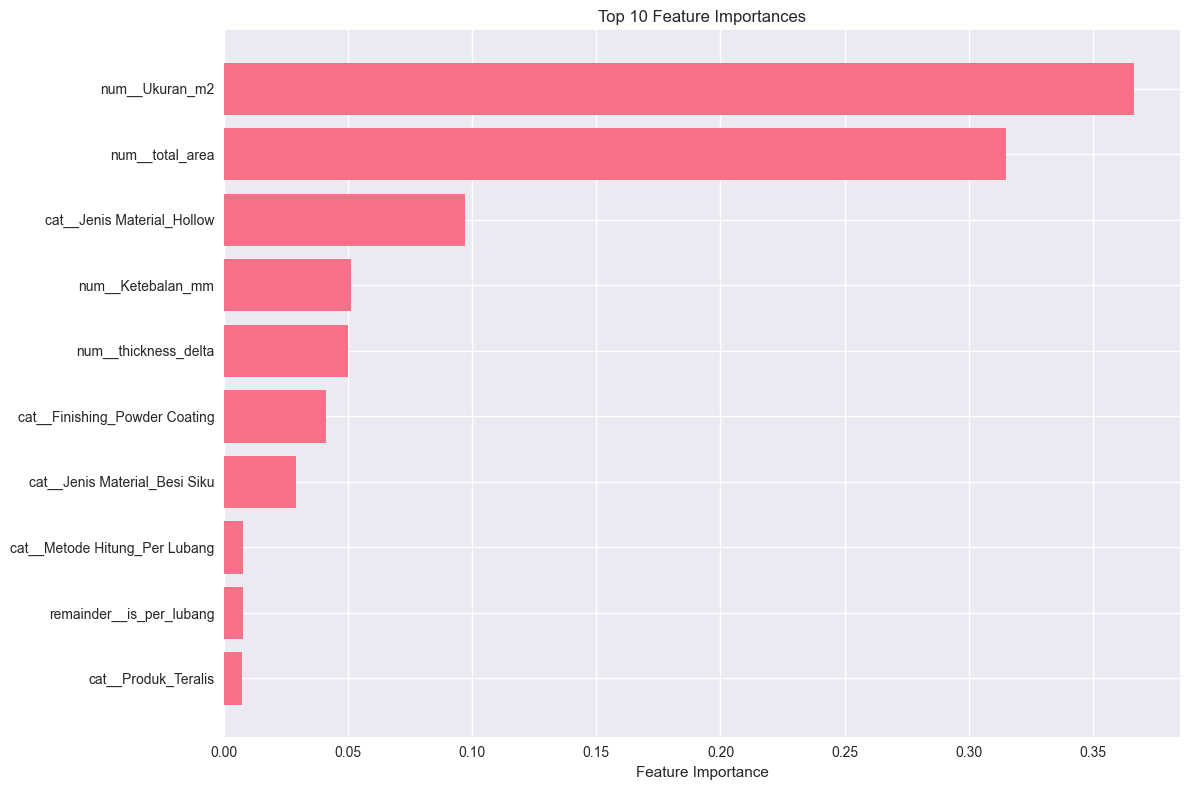

=== TOP 10 FEATURE IMPORTANCES ===
num__Ukuran_m2: 0.3668
num__total_area: 0.3151
cat__Jenis Material_Hollow: 0.0972
num__Ketebalan_mm: 0.0510
num__thickness_delta: 0.0501
cat__Finishing_Powder Coating: 0.0411
cat__Jenis Material_Besi Siku: 0.0289
cat__Metode Hitung_Per Lubang: 0.0079
remainder__is_per_lubang: 0.0077
cat__Produk_Teralis: 0.0071


In [16]:
# Load feature importances
with open('feature_importances.json', 'r') as f:
    feature_importances = json.load(f)
    
# Plot top 10 feature importances
top_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:10]
features, importances = zip(*top_features)

plt.figure(figsize=(12, 8))
plt.barh(range(len(features)), importances)
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

print("=== TOP 10 FEATURE IMPORTANCES ===")
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")

## Summary

From our exploratory analysis, we can observe:

1. The target variable (Harga Akhir) has a wide range, from Rp 100,000 to over Rp 50,000,000
2. Teralis is the most common product type, but Pintu Gerbang has the highest average price
3. Hollow is the most commonly used material
4. There's a positive correlation between size (Ukuran) and price
5. Our model achieved a good R² score of 0.87 on the test set, indicating it explains 87% of the variance in prices
6. The most important features for predicting price are related to size (Ukuran_m2 and total_area), followed by material type and finishing